In [170]:
###### Library de base
import pandas as pd
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import gc

###### Librabary Sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor

###### Library LightGBM



import lightgbm as lgb

# Importation de la base

In [171]:
##############
#### Importation de toute la base
##############


train=pd.read_csv("train.csv",sep=",")
weather_train=pd.read_csv("weather_train.csv",sep=",")
building_meta=pd.read_csv("building_metadata.csv",sep=',')

# Definition de fonction


In [173]:

##############
#### Fonction pour réduire la taille de la base
##############


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Source : https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction


##############
#### Fonction pour calculer les données manquantes
##############

def val_manq(df):
    percent = (df.isnull().sum()).sort_values(ascending=False)
    percent.plot(kind='bar', figsize = (20,10), fontsize=20)
    plt.xlabel('Colonnes')
    plt.ylabel('Nombre de lignes')
    plt.title('Tot valeur manquante')


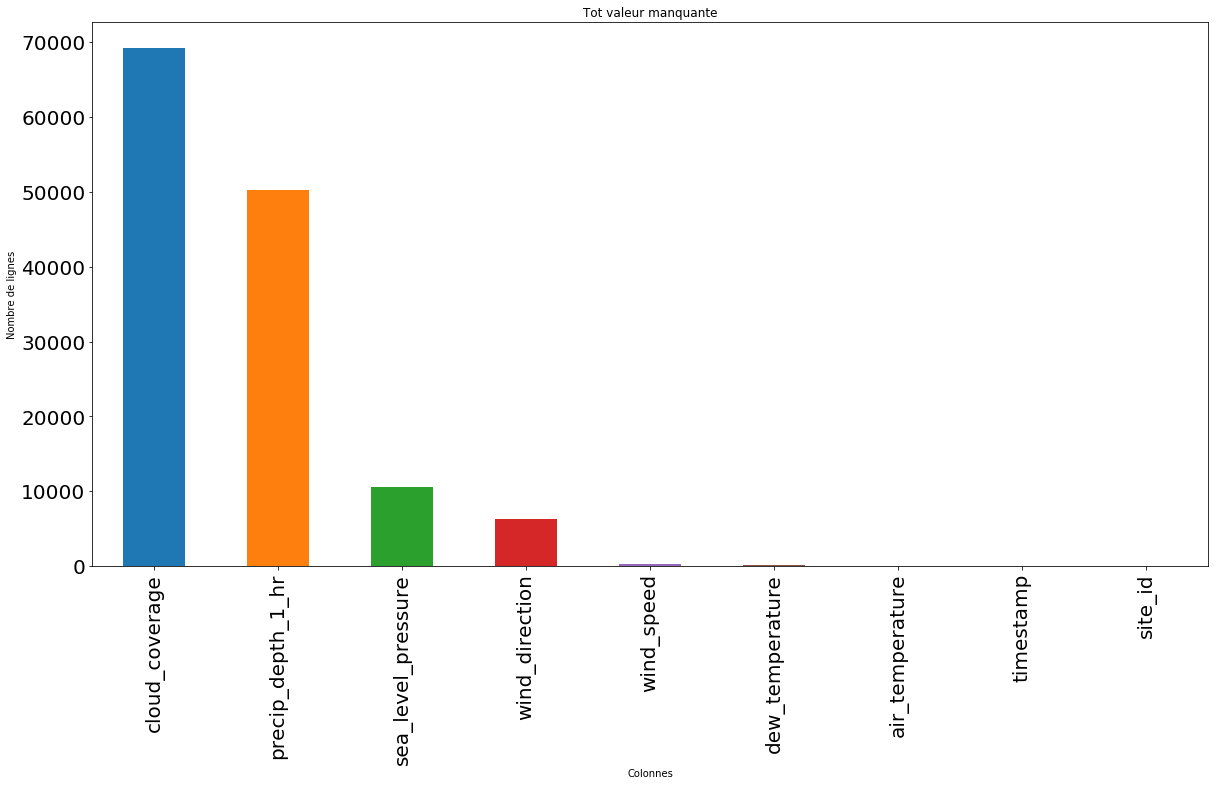

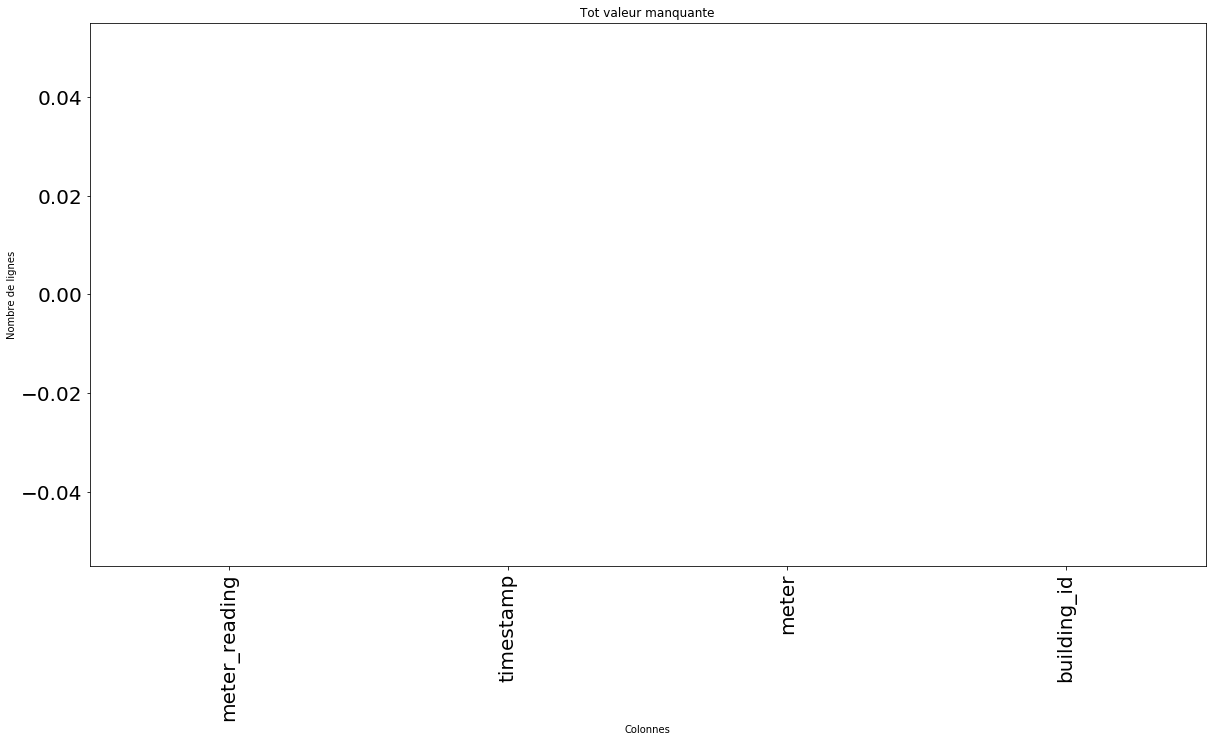

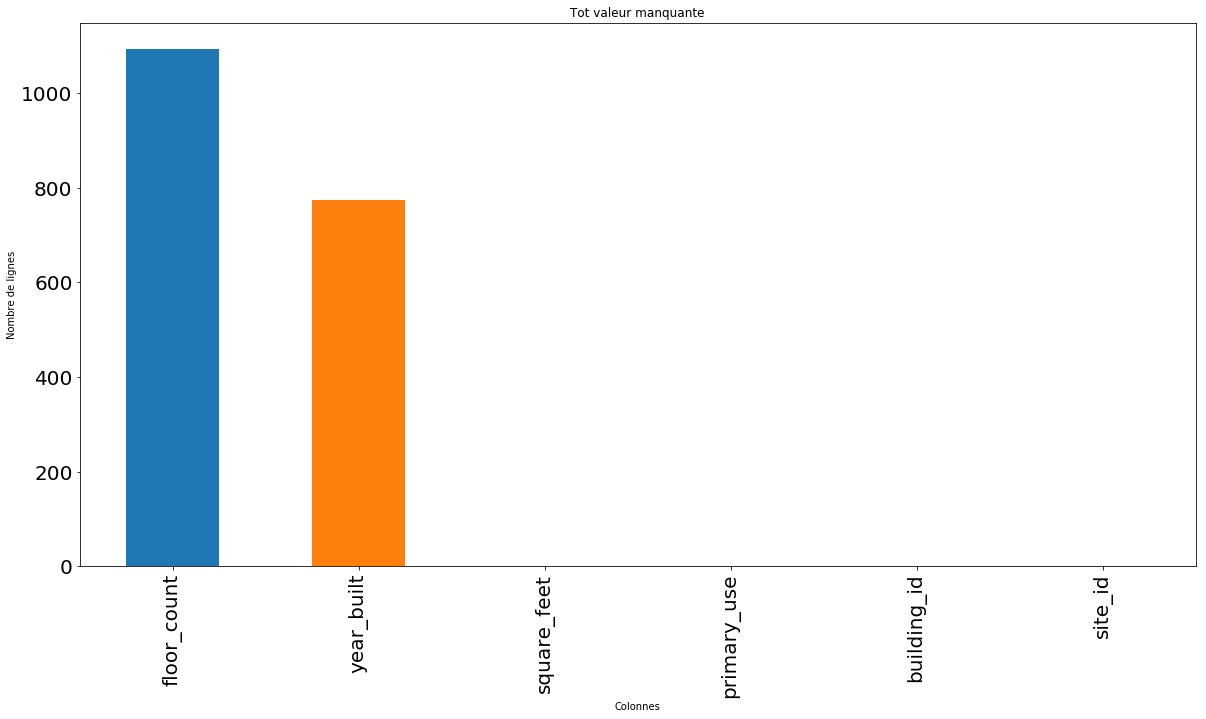

In [174]:

##############
#### Visualisation des valeurs manquantes
##############


val_manq(weather_train)
plt.show()
val_manq(train)
plt.show()
val_manq(building_meta)


In [175]:
# Remplissage des données manquantes

print("Date du début de l'étude : "+ min(train["timestamp"]))
print("Date de la fin de l'étude : "+max(train["timestamp"]))



Date du début de l'étude : 2016-01-01 00:00:00
Date de la fin de l'étude : 2016-12-31 23:00:00


In [176]:
##############
#### En comparant le nombre d'heure en 2016 et le nombre d'heure dans 
#### la base weather on comprend bien qu'il y a un pb.
##############


print("Nombre d'heures dans l'année 2016 : " + str(366*24)) 
print("Nombre d'heures pour chaque site dans l'année 2016 : " + str(366*24*16)) 
print("Nombre d'heures dans la base weather : " + str(len(weather_train["timestamp"])))

Nombre d'heures dans l'année 2016 : 8784
Nombre d'heures pour chaque site dans l'année 2016 : 140544
Nombre d'heures dans la base weather : 139773


In [177]:
##############
#### Problème de date manquante
##############

format_date = "%Y-%m-%d %H:%M:%S"

date_deb = min(weather_train["timestamp"])
date_fin = max(weather_train["timestamp"])

diff = 366*24 # Nombres d'heures pendant toute la durée de l'étude

début = datetime.datetime.strptime(date_deb,format_date)
# date time de la valeur de départ de l'étude
fin = datetime.datetime.strptime(date_fin,format_date)
# date time de la valeur de fin de l'étude

date_list = [(début + datetime.timedelta(hours=x)).strftime(format_date) for x in range(diff)]
# Création d'une liste de date sous le format timestamp

for i in range(0,16):
    heure_site = weather_train[weather_train["site_id"]==i]["timestamp"]
    heure_site = heure_site.values.tolist()
    heure_manquante = list(set(date_list)-set(heure_site))
    rangs_manquants = pd.DataFrame({'timestamp' : heure_manquante,'site_id' : i})
    weather_train = pd.concat([rangs_manquants,weather_train],sort=False)
# Créations des lignes manquantes de la base

In [178]:
##############
#### Création de nouvelles colonnes
##############

weather_train["datetime"] = pd.to_datetime(weather_train["timestamp"])
weather_train["annee"] = weather_train["datetime"].dt.year
weather_train["mois"] = weather_train["datetime"].dt.month
weather_train["semaine"] = weather_train["datetime"].dt.week
weather_train["jour"] = weather_train["datetime"].dt.day
weather_train["heure"] = weather_train["datetime"].dt.hour
weather_train.drop(columns=["datetime"],inplace=True)

In [179]:
##############
#### Remplissage des données manquantes de la base weather par des moyennes
##############


col_weather=["air_temperature","cloud_coverage","dew_temperature","precip_depth_1_hr","sea_level_pressure","wind_direction","wind_speed"]
mean_weather=weather_train.groupby(["site_id","mois"]).transform(lambda x: x.fillna(x.mean()))
for col in col_weather:
    weather_train[col] = mean_weather[col]
weather_train=weather_train.fillna(method='ffill')


# Manipulation de la base

In [180]:
##############
#### Encoding d'une variables qualitative
##############
#A faire après les graphiques

labelencoder=LabelEncoder()
building_meta["primary_use"] = labelencoder.fit_transform(building_meta["primary_use"])

In [181]:

##############
#### Merge des 3 bases
##############



df=pd.merge(train,building_meta, left_on='building_id', right_on='building_id')
df=pd.merge(df,weather_train, on=['timestamp','site_id'])
df = reduce_mem_usage(df)


Mem. usage decreased to 10.27 Mb (69.2% reduction)


In [182]:
##############
#### Conversion d'unité d'un certain type de meter à un certain endroit
##############

df.loc[(df["site_id"] == 0) & (df["meter"] == 0), "meter_reading"]=df.loc[(df["site_id"] == 0) & (df["meter"] == 0), "meter_reading"]*0.2931


# Data Vizualisation

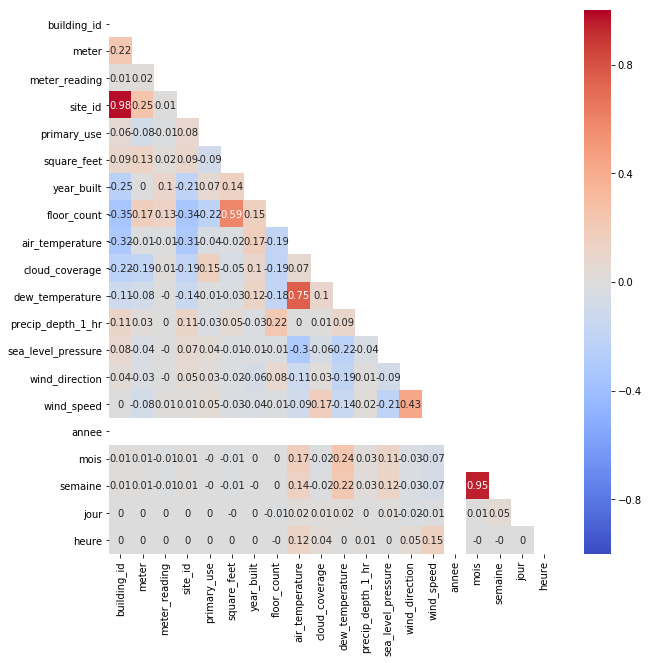

In [183]:
#matrice de correlation
corr= df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (10,10))
ax = sns.heatmap(corr.round(2), mask=mask,
            vmin=-1,     
            cmap='coolwarm',
            annot=True)

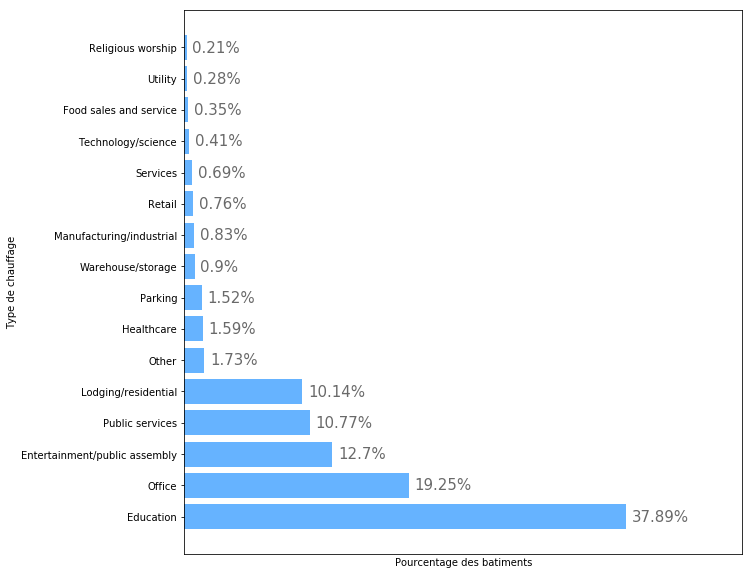

In [184]:
primary_use=building_meta["primary_use"].value_counts().reset_index()
primary_use_perc=primary_use["primary_use"]*100/sum(primary_use["primary_use"])
nom=['Education','Office','Entertainment/public assembly' ,'Public services','Lodging/residential' ,'Other' ,'Healthcare','Parking','Warehouse/storage','Manufacturing/industrial','Retail','Services','Technology/science','Food sales and service','Utility','Religious worship']
y_position=range(0,len(primary_use))


plt.figure(figsize=(10,10))
A=plt.barh(y_position,primary_use_perc,
       color='#66b3ff', align="center")
plt.yticks(y_position,nom)

for k in range(len(primary_use_perc)):
    plt.text(primary_use_perc[k]+0.5,
             y_position[k]-0.15, 
             str(round(primary_use_perc[k],2))+'%', 
             fontsize=15,
             color='dimgrey')
    

plt.xlim([0, max(primary_use_perc)+10])
# Enléve l'échelle de l'axe x
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel("Pourcentage des batiments")
plt.ylabel('Type de chauffage')
plt.show()


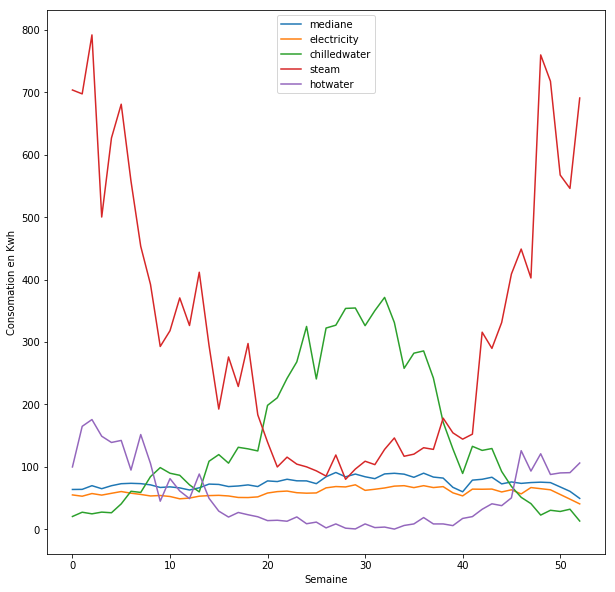

In [185]:
##############
#### Calcul des consommations moyennes de chaques meter type par semaine
##############

mediane_conso_semaine = df.groupby(['semaine']).median()
mediane_conso_semaine_0 = df[df["meter"]==0].groupby(['semaine']).median()
mediane_conso_semaine_1 = df[df["meter"]==1].groupby(['semaine']).median()
mediane_conso_semaine_2 = df[df["meter"]==2].groupby(['semaine']).median()
mediane_conso_semaine_3 = df[df["meter"]==3].groupby(['semaine']).median()

##############
#### Plot Standard
##############


plt.figure(figsize=(10,10))
plt.plot(range(0,len(mediane_conso_semaine)),mediane_conso_semaine["meter_reading"],label='mediane')
plt.plot(range(0,len(mediane_conso_semaine)),mediane_conso_semaine_0["meter_reading"],label='electricity')
plt.plot(range(0,len(mediane_conso_semaine)),mediane_conso_semaine_1["meter_reading"],label='chilledwater')
plt.plot(range(0,len(mediane_conso_semaine)),mediane_conso_semaine_2["meter_reading"],label='steam')
plt.plot(range(0,len(mediane_conso_semaine)),mediane_conso_semaine_3["meter_reading"],label='hotwater')
plt.ylabel('Consomation en Kwh')
plt.xlabel('Semaine')
plt.legend()
#plt.savefig('mediane_conso-semaine_primary_use.png')

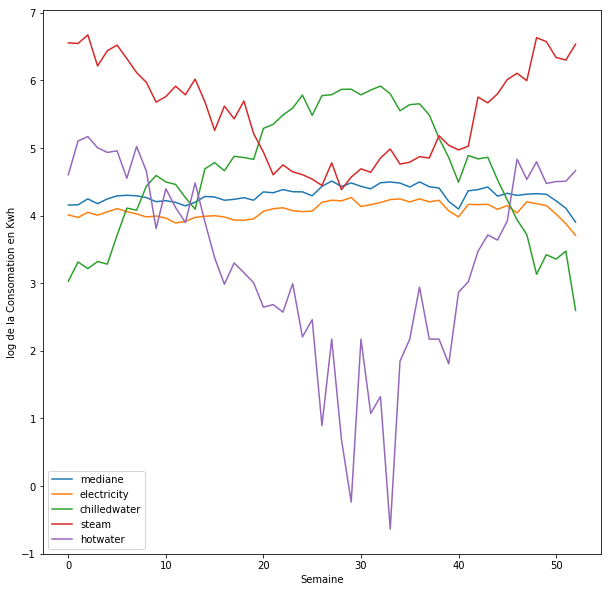

In [186]:
##############
#### Plot Log de la valeur
##############



plt.figure(figsize=(10,10))
plt.plot(range(0,len(mediane_conso_semaine)),np.log(mediane_conso_semaine["meter_reading"]),label='mediane')
plt.plot(range(0,len(mediane_conso_semaine)),np.log(mediane_conso_semaine_0["meter_reading"]),label='electricity')
plt.plot(range(0,len(mediane_conso_semaine)),np.log(mediane_conso_semaine_1["meter_reading"]),label='chilledwater')
plt.plot(range(0,len(mediane_conso_semaine)),np.log(mediane_conso_semaine_2["meter_reading"]),label='steam')
plt.plot(range(0,len(mediane_conso_semaine)),np.log(mediane_conso_semaine_3["meter_reading"]),label='hotwater')
plt.ylabel('log de la Consomation en Kwh')
plt.xlabel('Semaine')
plt.legend()
plt.savefig('semaine_conso.png')

del mediane_conso_semaine
del mediane_conso_semaine_0
del mediane_conso_semaine_1
del mediane_conso_semaine_2
del mediane_conso_semaine_3

Text(0.5, 0, 'value')

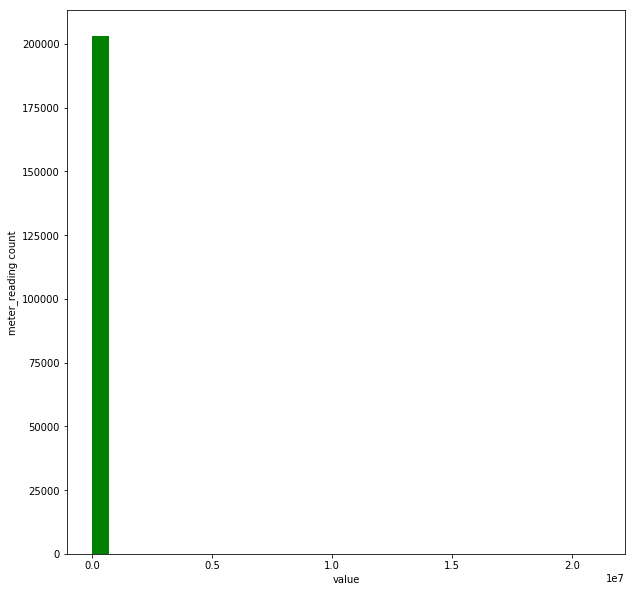

In [187]:
############
### meter_reading avant log
############
plt.figure(figsize=(10,10))
plt.hist(train["meter_reading"],bins=30,color='green')
plt.ylabel('meter_reading count')
plt.xlabel('value')
#plt.savefig('meter_reading_no_log.png')

Text(0.5, 0, 'value')

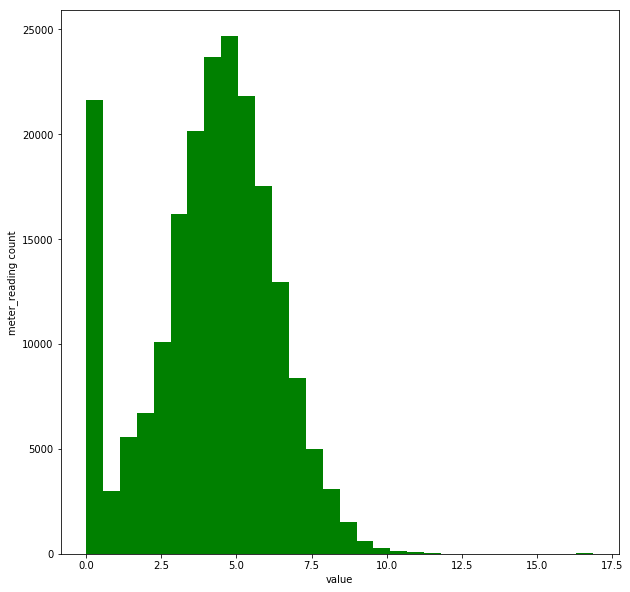

In [188]:
############
### meter_reading après log
############
plt.figure(figsize=(10,10))
plt.hist(np.log1p(train["meter_reading"]),bins=30,color='green')
plt.ylabel('meter_reading count')
plt.xlabel('value')
#plt.savefig('meter_reading_log.png')

Analyse du site 13 :

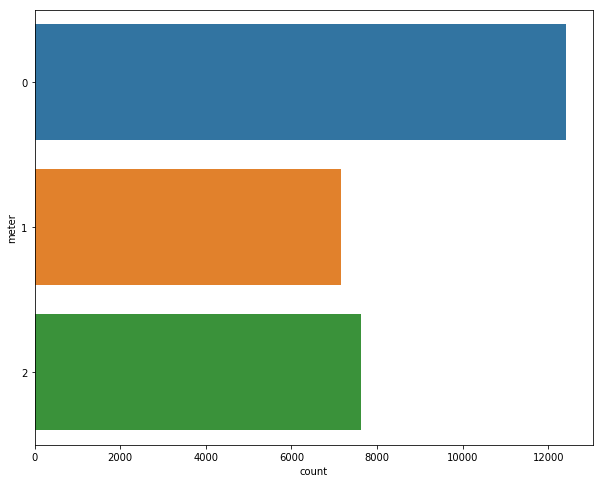

In [189]:
##############
#### Représentation de "indicator of the primary category of activities of the 
#### building"
##############

fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(y='meter', data=df[df['site_id']==13])
#plt.savefig('primary_use_build.png')

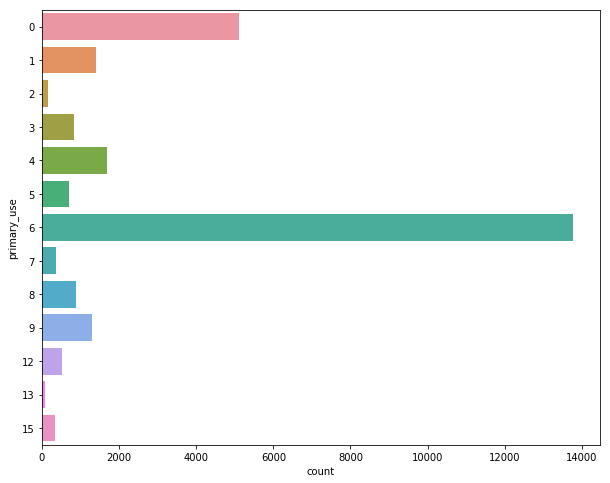

In [190]:
##############
#### Représentation de "indicator of the primary category of activities of the 
#### building"
##############

fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(y='primary_use', data=df[df['site_id']==13])
#plt.savefig('primary_use_build.png')

In [191]:
df[df['site_id'] == 13].describe()

D:\Programme\Anaconda\lib\site-packages\pandas\core\nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)
D:\Programme\Anaconda\lib\site-packages\pandas\core\nanops.py:121: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,annee,mois,semaine,jour,heure
count,27181.000000,27181.000000,2.718100e+04,27181.0,27181.000000,27181.000000,0.0,0.0,2.718100e+04,2.718100e+04,2.718100e+04,27181.000000,2.718100e+04,2.718100e+04,2.718100e+04,27181.0,27181.000000,27181.000000,27181.000000,27181.000000
mean,1145.414260,0.823406,1.599211e+04,13.0,4.827343,147537.300246,NaN,NaN,inf,inf,inf,0.871582,inf,inf,inf,2016.0,6.486884,26.491998,15.822523,11.506457
std,44.527911,0.840003,4.767890e+05,0.0,3.132215,138993.645963,NaN,NaN,1.238281e+01,1.944336e+00,1.134375e+01,8.015625,7.613281e+00,1.038750e+02,2.330078e+00,0.0,3.447774,15.090648,8.793129,6.930173
min,1069.000000,0.000000,0.000000e+00,13.0,0.000000,10385.000000,NaN,NaN,-2.829688e+01,0.000000e+00,-3.109375e+01,-1.000000,9.815000e+02,0.000000e+00,0.000000e+00,2016.0,1.000000,1.000000,1.000000,0.000000
25%,1105.000000,0.000000,2.343750e+01,13.0,3.000000,70040.000000,NaN,NaN,6.000977e-01,2.000000e+00,-3.900391e+00,0.000000,1.011500e+03,1.300000e+02,2.599609e+00,2016.0,3.000000,13.000000,8.000000,5.000000
50%,1148.000000,1.000000,1.174990e+02,13.0,6.000000,100813.000000,NaN,NaN,1.110156e+01,2.830078e+00,3.900391e+00,0.000000,1.016000e+03,1.800000e+02,4.101562e+00,2016.0,6.000000,26.000000,16.000000,12.000000
75%,1184.000000,2.000000,5.571100e+02,13.0,6.000000,192152.000000,NaN,NaN,2.000000e+01,3.761719e+00,1.279688e+01,0.000000,1.021000e+03,2.800000e+02,5.699219e+00,2016.0,9.000000,40.000000,23.000000,18.000000
max,1222.000000,2.000000,2.116270e+07,13.0,15.000000,861524.000000,NaN,NaN,3.559375e+01,9.000000e+00,2.500000e+01,216.000000,1.040000e+03,3.600000e+02,1.600000e+01,2016.0,12.000000,53.000000,31.000000,23.000000


Consommation d'énergie en fonction des catégories d'utilisation des bâtiments et du type d'énergie 

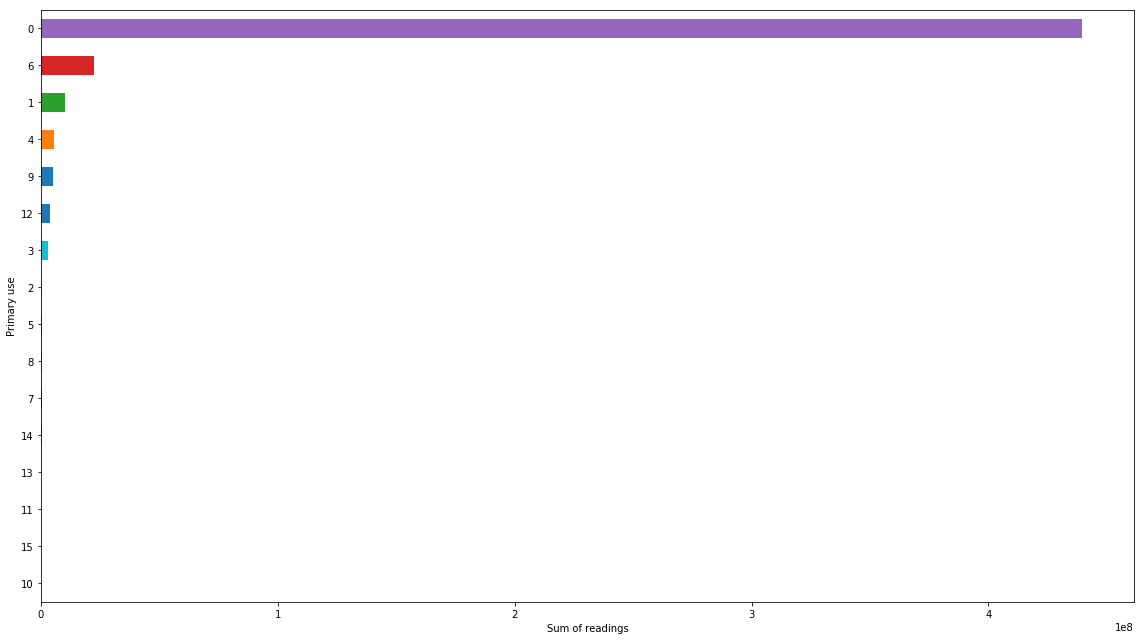

In [192]:

temp_df = df.groupby("primary_use").meter_reading.sum().sort_values()

plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use")
plt.tight_layout()
plt.show()

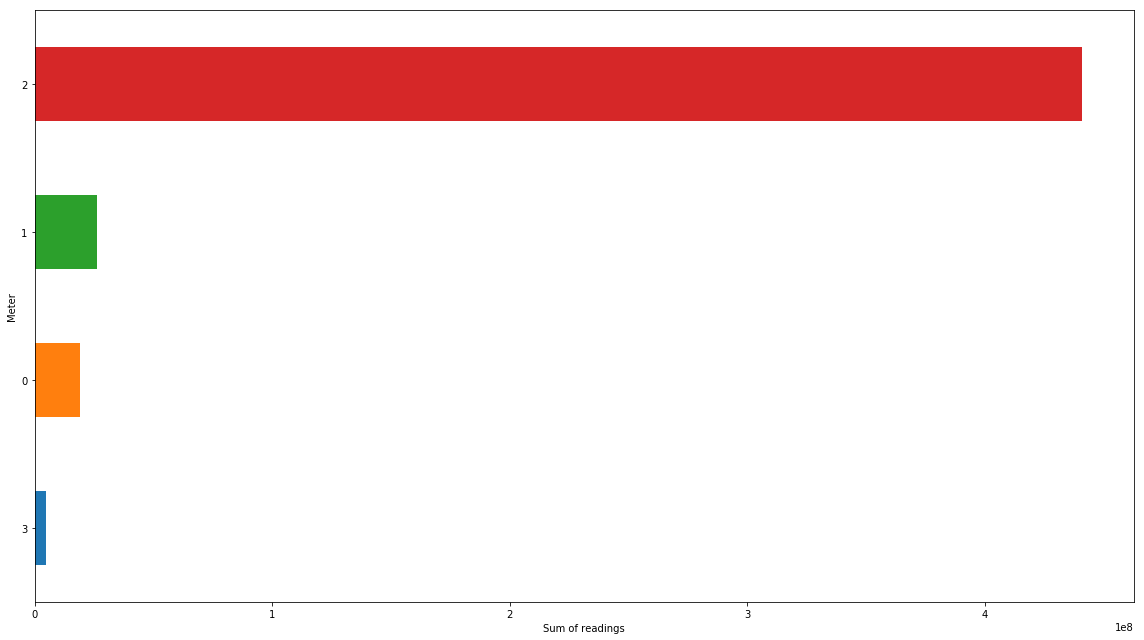

In [193]:

temp_df = df.groupby("meter").meter_reading.sum().sort_values()

plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.xlabel("Sum of readings")
plt.ylabel(f"Meter")
plt.tight_layout()
plt.show()


Analyse de la consommation d'énergie par site en total et par médiane

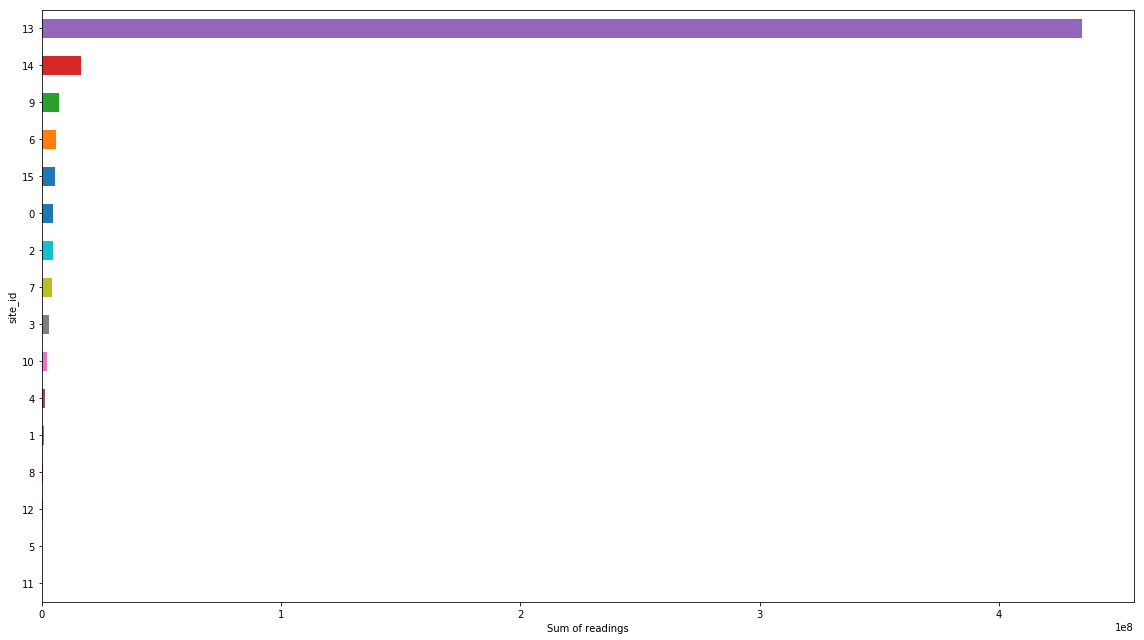

In [194]:

temp_df = df.groupby("site_id").meter_reading.sum().sort_values()

plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.xlabel("Sum of readings")
plt.ylabel(f"site_id")
plt.tight_layout()
plt.show()


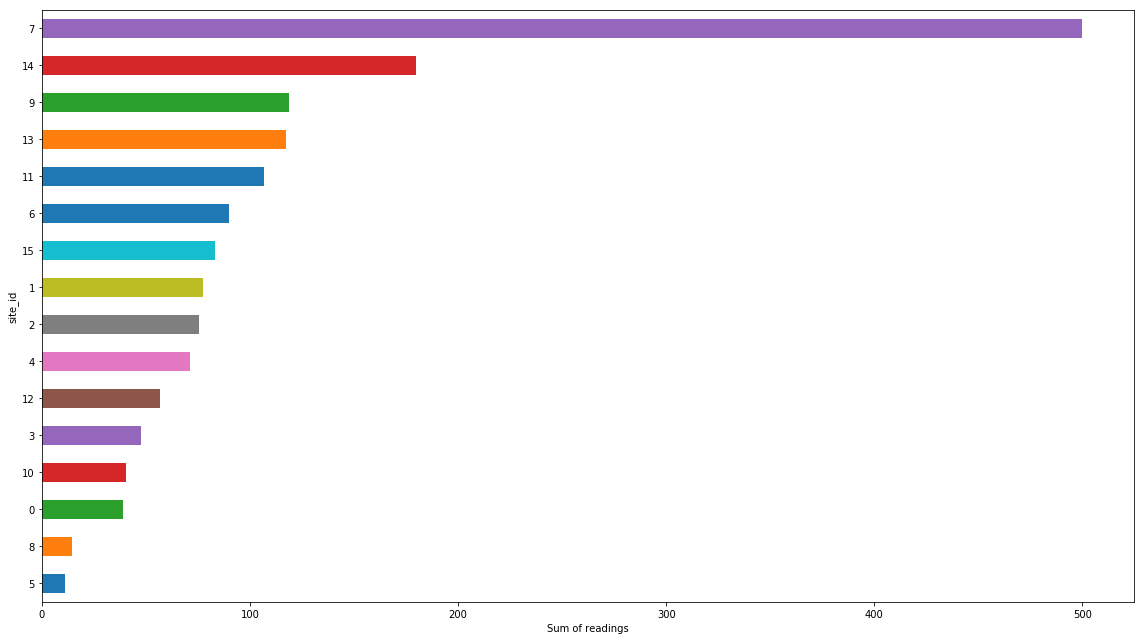

In [195]:
temp_df = df.groupby("site_id").meter_reading.median().sort_values()

plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.xlabel("Sum of readings")
plt.ylabel(f"site_id")
plt.tight_layout()
plt.show()

Représentation de la consomamtion des bâtiments par année de construction

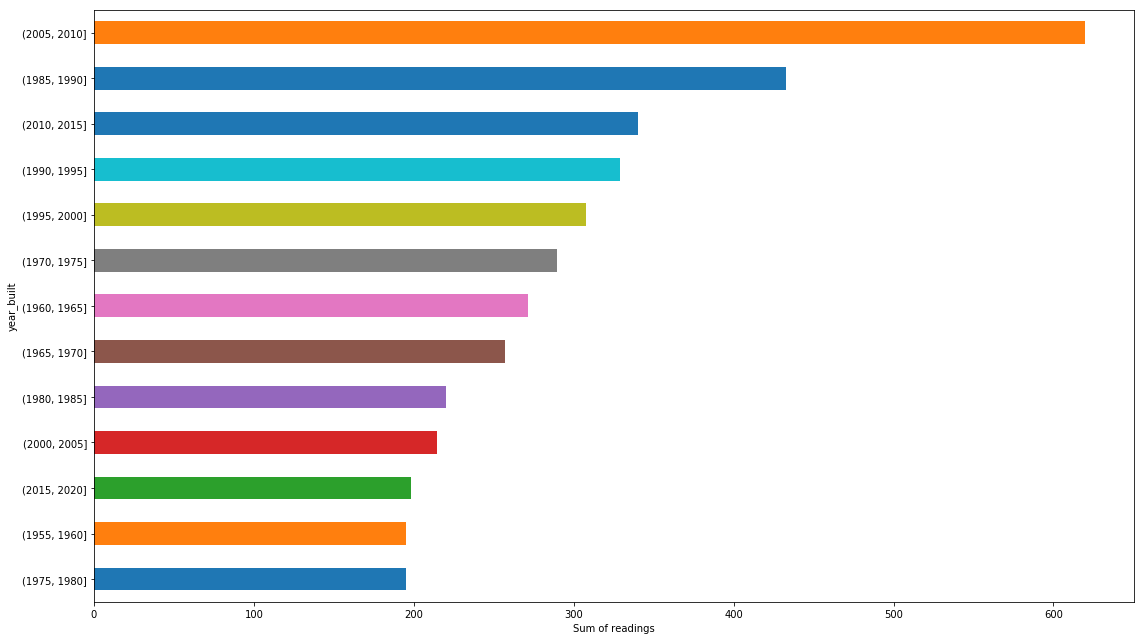

In [196]:
df['year_built_bin'] = pd.cut(x=df['year_built'], bins=[1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])
temp_df = df.groupby("year_built_bin").meter_reading.mean().sort_values()


plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.xlabel("Sum of readings")
plt.ylabel(f"year_built")
plt.tight_layout()
plt.savefig('building_built_moy_5grp.png')
plt.show()

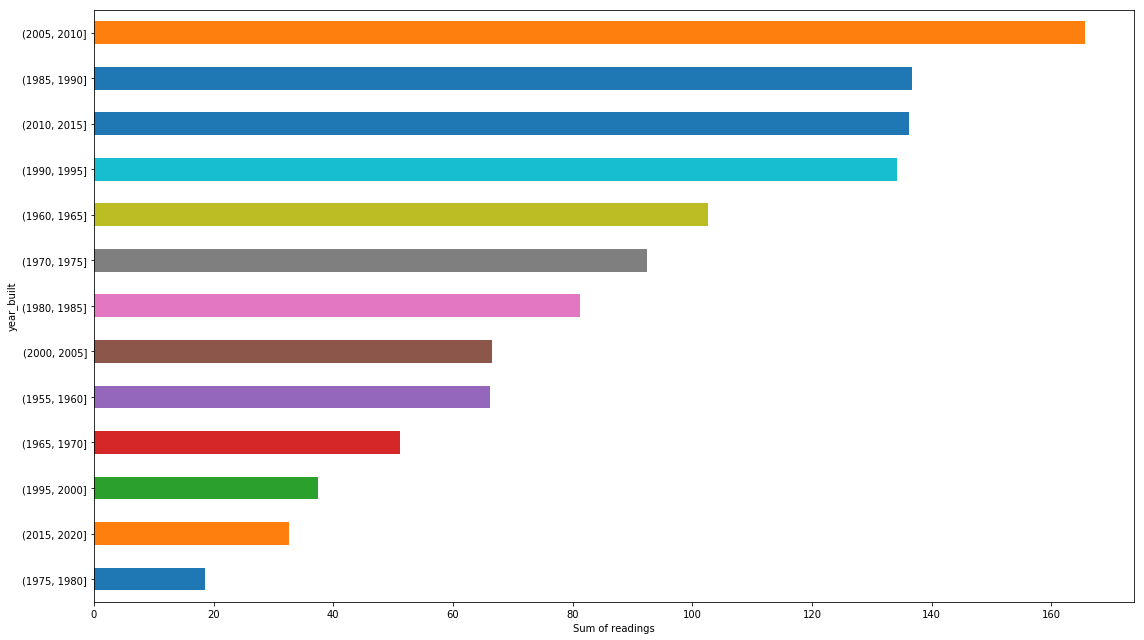

In [197]:
temp_df = df.groupby("year_built_bin").meter_reading.median().sort_values()


plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.xlabel("Sum of readings")
plt.ylabel(f"year_built")
plt.tight_layout()
plt.savefig('building_built__med_5grp.png')
plt.show()


# Split des données en Apprentissage/Test

In [198]:
##############
#### Suppression des bases initiales
##############

del train
del weather_train
del building_meta

In [199]:
##############
#### Création de la variable cible et des variables explicatioves
#### Split en App/Test
##############

df.drop(columns=["year_built","floor_count"],inplace=True)


X=df.drop(columns=["meter_reading","timestamp","year_built_bin"])
y=np.log1p(df["meter_reading"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


del X
del y
del df

gc.collect();

# Modèle de Prédiction



## KNN

### Modèle de base

In [200]:
knn = KNeighborsRegressor(n_jobs=-1, weights='distance') # K = 5 par défauts
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)


The rmse of prediction is: 1.6467197418801354


### Recherche du meilleur modèle

In [201]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
k_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
erreur_knn = []
for i in range(0,len(k_range)):
    knn = KNeighborsRegressor(n_neighbors=k_range[i],n_jobs=-1, weights='distance')
    knn.fit(X_train_knn,y_train_knn)
    y_pred = knn.predict(X_test_knn)
    erreur = mean_squared_error(y_test_knn, y_pred)**0.5
    erreur_knn.append(erreur)

del X_train_knn
del X_test_knn
del y_test_knn
del y_train_knn
del y_pred

gc.collect();

In [202]:
erreur_knn

[1.6561962535496904,
 1.6082806234738527,
 1.5969570478320212,
 1.5942144992361518,
 1.5943206143764668,
 1.594470913291468,
 1.596054010146177,
 1.5966413618455235,
 1.5978897551987876,
 1.5991210987792446,
 1.6002793061882121,
 1.6015990390847439,
 1.602939075845348,
 1.6041606462098295]

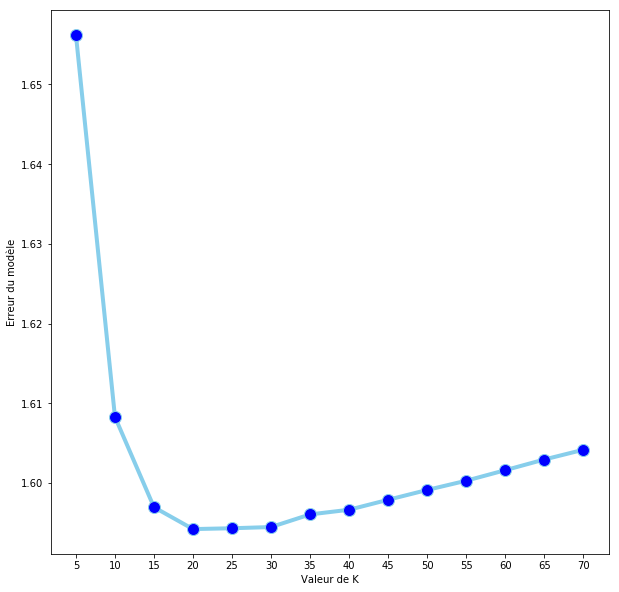

In [203]:
plt.figure(figsize=(10,10))
plt.plot(k_range,erreur_knn , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.xlabel("Valeur de K")
plt.ylabel("Erreur du modèle")
plt.xticks(k_range,k_range);

#### Résultat de la recherche
Valeur = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]  :  
-Résultat = [1.660315121583663, 1.5799791843467181, 1.5444780998289551, 1.5241509842625436,1.5111512882369214, 1.5021696018398543,1.495729114354016, 1.4910569465040882, 1.4874995481154836, 1.4847853887052653, 1.4826815606432966, 1.481047281033797,1.4797644928403906, 1.4787621572620613]


### Test du meilleur modèle

In [204]:
knn_best = KNeighborsRegressor(n_jobs=-1, weights='distance', n_neighbors=55) 
knn_best.fit(X_train,y_train)
y_pred = knn_best.predict(X_test)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 1.5882594002273926


## Random Forest

### Paramètre nécessaire

In [205]:
##############
#### Création de forets dans le but de réduire la demande mémoire
##############


from sklearn.ensemble import forest
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
set_rf_samples(130000)


def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

### Random Forest de base

In [206]:
model = RandomForestRegressor(random_state=0,
                              n_jobs=-1); # n_estimators = 10
model.fit(X_train,y_train);

y_pred=model.predict(X_test);
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The rmse of prediction is: 0.9348755306700619


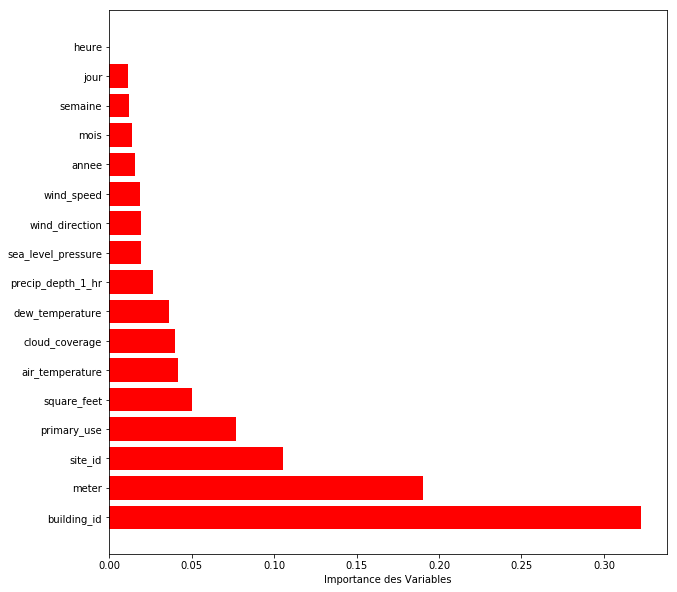

In [207]:
##############
#### Importance des variables dans la foret d'arbre
##############

feature_names = X_train.columns
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.xlabel("Importance des Variables")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(X_train.shape[1]), feature_names)
#plt.xlim([-1, X_train.shape[1]])
plt.show()

### Recherche du meilleur modèle

In [208]:
##############
#### Choix des paramètres 
##############


X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Paramètre

n_estimators =[10, 30, 50, 70, 100, 130, 160, 190, 220]
erreur_rf = []
for i in range(0,len(n_estimators)):
    rf = RandomForestRegressor(n_estimators=n_estimators[i],random_state=0,n_jobs=-1)
    rf.fit(X_train_rf,y_train_rf)
    y_pred = rf.predict(X_test_rf)
    erreur = mean_squared_error(y_test_rf, y_pred)**0.5
    erreur_rf.append(erreur)

del X_train_rf
del X_test_rf
del y_train_rf
del y_test_rf

gc.collect();

In [209]:
print(erreur_rf)

[0.9820103204982775, 0.9468227837245625, 0.9397836903716219, 0.938074307467275, 0.9348922732872295, 0.934014836883567, 0.9329604675279041, 0.9337708595794852, 0.9340239737376523]


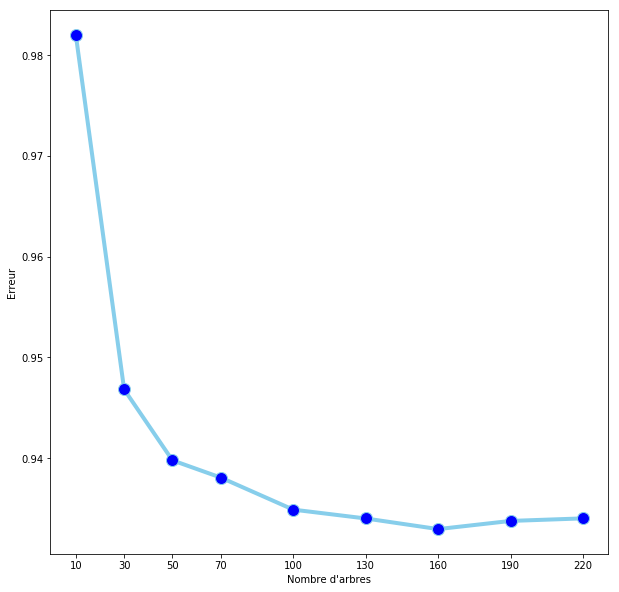

In [210]:
erreur_n_estimators = erreur_rf
plt.figure(figsize=(10,10))
plt.plot(n_estimators,erreur_n_estimators, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4);
plt.xlabel("Nombre d'arbres")
plt.ylabel("Erreur")
plt.xticks(n_estimators,n_estimators);

In [211]:
##############
#### Choix des paramètres 
##############


X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Paramètre
max_depth = [10,20, 30, 40, 50, 60, 70, 80, 90, 100, None]
erreur_rf = []
for i in range(0,len(max_depth)):
    rf = RandomForestRegressor(max_depth=max_depth[i],random_state=0,n_jobs=-1 )
    rf.fit(X_train_rf,y_train_rf)
    y_pred = rf.predict(X_test_rf)
    erreur = mean_squared_error(y_test_rf, y_pred)**0.5
    erreur_rf.append(erreur)

del X_train_rf
del X_test_rf
del y_train_rf
del y_test_rf

gc.collect();

D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: T

In [212]:
print(erreur_rf)

[1.3850540746266433, 0.9989029597755779, 0.9799453001390934, 0.9795559380150279, 0.9818825223525419, 0.9820103204982775, 0.9820103204982775, 0.9820103204982775, 0.9820103204982775, 0.9820103204982775, 0.9820103204982775]


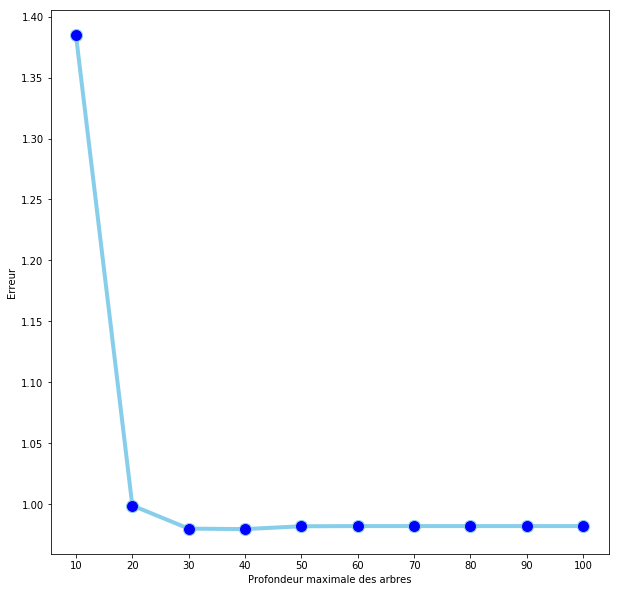

In [213]:
erreur_max_depth = erreur_rf
plt.figure(figsize=(10,10))
plt.plot(max_depth,erreur_max_depth, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4);
plt.xlabel("Profondeur maximale des arbres")
plt.ylabel("Erreur")
plt.xticks(max_depth[:-1],max_depth[:-1]); # Car le None ne peut pas être affiché

In [214]:
##############
#### Choix des paramètres 
##############


X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Paramètre
min_samples_split = [2, 5, 10, 20 ,30]
erreur_rf = []
for i in range(0,len(min_samples_split)):
    rf = RandomForestRegressor(min_samples_split=min_samples_split[i],random_state=0,n_jobs=-1 )
    rf.fit(X_train_rf,y_train_rf)
    y_pred = rf.predict(X_test_rf)
    erreur = mean_squared_error(y_test_rf, y_pred)**0.5
    erreur_rf.append(erreur)

del X_train_rf
del X_test_rf
del y_train_rf
del y_test_rf

gc.collect();


D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Programme\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: T

In [215]:
print(erreur_rf)

[0.9820103204982775, 0.9776911377506096, 0.980456685013683, 0.997772089210017, 1.0227809064403182]


In [216]:
erreur_min_samples_split = erreur_rf

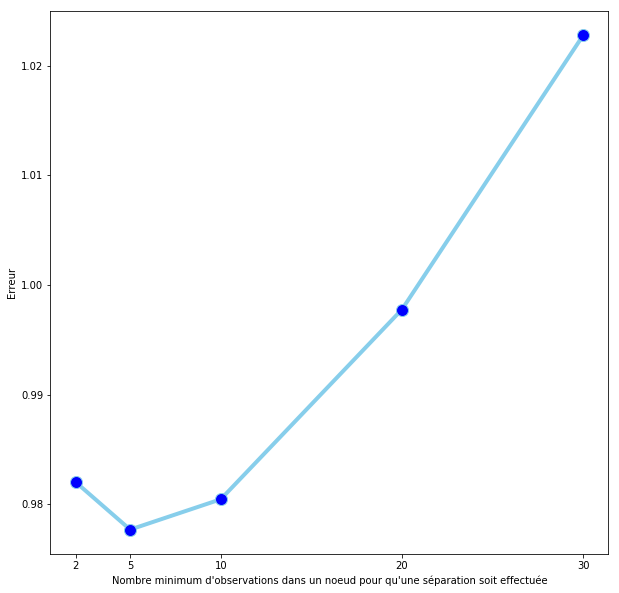

In [217]:
plt.figure(figsize=(10,10))
plt.plot(min_samples_split,erreur_min_samples_split, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4);
plt.xlabel("Nombre minimum d'observations dans un noeud pour qu'une séparation soit effectuée")
plt.ylabel("Erreur")
plt.xticks(min_samples_split,min_samples_split); # Car le None ne peut pas être affiché

#### Résultat de la recherche

n_estimators = [10, 30, 50, 70, 100, 130, 160, 190, 220] :
- erreur = [0.8361054027017335, 0.7968092040149114, 0.7896074110110385, 0.7867732388450902, 0.7832596986819509, 0.7817079650265579, 0.7804837745630923,0.7802371972002211, 0.7797987830671329]

max_depth = [10,20, 30, 40, 50, 60, 70, 80, 90, 100, None] :
- erreur = [1.3591750963091456, 0.862434809822269, 0.8367067814091884, 0.836555349584275, 0.8361054027017335, 0.8361054027017335, 0.8361054027017335, 0.8361054027017335, 0.8361054027017335, 0.8361054027017335, 0.8361054027017335]

min_samples_split = [2, 5, 10, 20 ,30] :
- erreur = [0.8361054027017335, 0.835373537152044, 0.8412791214927986, 0.8654151778058987, 0.8917872715630332]


### Meilleur modèle


In [218]:
best_model_rf = RandomForestRegressor(max_depth=30,n_estimators = 130, min_samples_split= 5,random_state=0,n_jobs=-1 )
best_model_rf.fit(X_train,y_train)
y_pred = best_model_rf.predict(X_test)
erreur = mean_squared_error(y_test, y_pred)**0.5
print('The rmsle of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmsle of prediction is: 0.8832840527673055


In [219]:
##############
#### Reset des forêts
##############

reset_rf_samples()


## Gradient Boosting avec LightGBM

In [220]:
##############
#### Création des DataSets de LightGBM & des paramètres de ses datasets
##############

categorical_features = ["building_id", "site_id", "meter", "primary_use"]

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_train, y_train, test_size=0.33, random_state=42)


lgb_train = lgb.Dataset(X_train_lgbm, 
                        label=y_train_lgbm,
                        categorical_feature=categorical_features,
                        free_raw_data=False)

lgb_eval = lgb.Dataset(X_test_lgbm, 
                       label=y_test_lgbm,
                       categorical_feature=categorical_features,
                       free_raw_data=False)




In [221]:
##############
#### Paramètre du gradient boosting
##############
evals_result = {} 
params_lgb = {
    "objective": "regression",
    "boosting": "gbdt",
    "learning_rate": 0.1,
    "feature_fraction": 0.85,
    "metric": "rmse",
}


In [222]:
##############
#### Entrainement du modele
##############

model_lgb = lgb.train(params_lgb, 
                train_set=lgb_train, 
                num_boost_round=1000, 
                valid_sets=[lgb_train,lgb_eval], 
                verbose_eval=50,
                evals_result=evals_result,
                early_stopping_rounds=50)

D:\Programme\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1.07183	valid_1's rmse: 1.12186
[100]	training's rmse: 0.947569	valid_1's rmse: 1.02642
[150]	training's rmse: 0.889532	valid_1's rmse: 0.9921
[200]	training's rmse: 0.851499	valid_1's rmse: 0.974017
[250]	training's rmse: 0.82946	valid_1's rmse: 0.964297
[300]	training's rmse: 0.805538	valid_1's rmse: 0.955975
[350]	training's rmse: 0.784794	valid_1's rmse: 0.944957
[400]	training's rmse: 0.762264	valid_1's rmse: 0.93435
[450]	training's rmse: 0.747391	valid_1's rmse: 0.929428
[500]	training's rmse: 0.729911	valid_1's rmse: 0.923042
[550]	training's rmse: 0.715019	valid_1's rmse: 0.918219
[600]	training's rmse: 0.702175	valid_1's rmse: 0.913828
[650]	training's rmse: 0.690209	valid_1's rmse: 0.910325
[700]	training's rmse: 0.677632	valid_1's rmse: 0.90817
[750]	training's rmse: 0.66561	valid_1's rmse: 0.905146
[800]	training's rmse: 0.653367	valid_1's rmse: 0.902864
[850]	training's rmse: 0.643503	valid

In [223]:
y_pred=model_lgb.predict(X_test);
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.8862185375086911


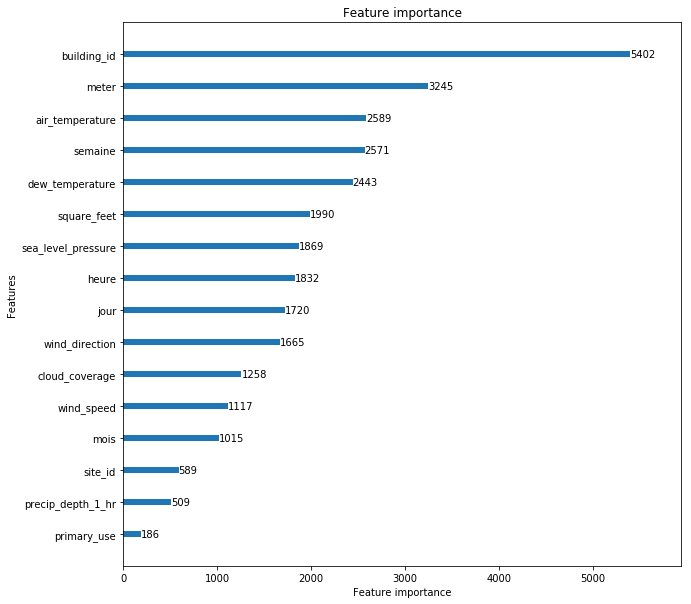

In [224]:
lgb.plot_importance(model_lgb, figsize=(10,10),grid=False)